In [9]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
from torchvision.transforms import Lambda
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights
import datetime
from PIL import Image

In [10]:
df = pd.read_csv('data.csv')
# convert label column to categorical codes
df['label_code'] = pd.Categorical(df.label).codes
# print the count of the most common and least common labels, and the average count
print(df.label.value_counts().head(1))
print(df.label.value_counts().tail(1))
print(df.label.value_counts().mean())
# create image_path column by combining ./data/{hash}.jpg where hash is the column md5hash of the row
df['image_path'] = './data/' + df.md5hash + '.jpg'
# create image_found column by checking if the image_path exists
df['image_found'] = df.image_path.map(os.path.exists)
# create orig_index column to store the original index of the row
df['orig_index'] = df.index
# filter only the rows where image_found is True
df = df[df.image_found == True]
# reset the index
df.reset_index(inplace=True)
# resample the data set to have equal number of samples for each class
#df_resampled = df.groupby('label_code').apply(lambda x: x.sample(200, replace=True)).reset_index(drop=True)
# we use stratified sampling to ensure that the distribution of the labels is the same in each set

# print resample dataset shape
#print('Data resampled: ', df_resampled.shape)


psoriasis    653
Name: label, dtype: int64
pilomatricoma    53
Name: label, dtype: int64
145.41228070175438


In [14]:



# split the data into train, validation, and test set using sklearn's train_test_split
# train has 70% of the data, validation has 15% of the data, and test has 15% of the data
# we use stratified sampling to ensure that the distribution of the labels is the same in each set

train_df, val_df = train_test_split(df, test_size=0.3, random_state=500, stratify=df.label_code)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=500, stratify=val_df.label_code)
# reset the index
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)


# drop the columns that we don't need
train_df.drop(columns=['index', 'level_0'], inplace=True)
val_df.drop(columns=['index', 'level_0'], inplace=True)
test_df.drop(columns=['index', 'level_0'], inplace=True)
# save to csv
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test500.csv', index=False)
# print the shape of each set
print('Train set: ' ,train_df.shape)
print('Validation set: ',val_df.shape)
print('Test set: ',test_df.shape)


Train set:  (11603, 13)
Validation set:  (2487, 13)
Test set:  (2487, 13)


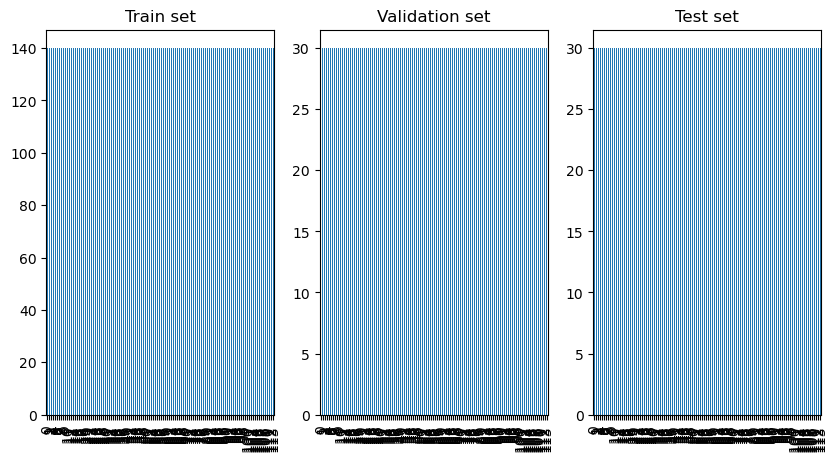

In [77]:
# plot the distribution of label_codes in train, validation, and test set. Each bar is a class  and the height of the bar is the number of samples in that class
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Train set')
train_df.label_code.value_counts().sort_index().plot(kind='bar')
plt.subplot(1, 3, 2)
plt.title('Validation set')
val_df.label_code.value_counts().sort_index().plot(kind='bar')
plt.subplot(1, 3, 3)
plt.title('Test set')
test_df.label_code.value_counts().sort_index().plot(kind='bar')
plt.show()



In [43]:
150*114

17100

In [27]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')
print('Train set: ' ,train_df.shape)
print('Validation set: ',val_df.shape)
print('Test set: ',test_df.shape)


In [18]:
print(f'Train: {len(train_df)}')
print(f'Validation: {len(val_df)}')
print(f'Test: {len(test_df)}')

Train: 15960
Validation: 3420
Test: 3420


In [19]:
train_df.head(2)

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum,label_code,image_path,image_found,orig_index
0,2fb8a083e009f50676dab57deb7f41be,3,4,dariers disease,genodermatoses,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=1314,httpwwwatlasdermatologicocombrimgimageId1314.jpg,15,./data/2fb8a083e009f50676dab57deb7f41be.jpg,True,13426
1,91f0e31271eb04d1186f3c90e7f42368,2,1,pityriasis rosea,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=5596,httpwwwatlasdermatologicocombrimgimageId5596.jpg,79,./data/91f0e31271eb04d1186f3c90e7f42368.jpg,True,14769


In [20]:
transforms = torchvision.transforms.Compose([
                     torchvision.transforms.RandomHorizontalFlip(p=0.5),
                     torchvision.transforms.RandomVerticalFlip(p=0.5),
                     torchvision.transforms.RandomRotation(degrees=30),
                     torchvision.transforms.RandomResizedCrop(size=[224, 224],
                                                              scale=(0.8, 1.2),
                                                              ratio=(0.7, 1.3)),
                     torchvision.transforms.RandomAffine(degrees=10),
                 ])

target_transform = Lambda(lambda y: torch.zeros(
    114, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

class MyDataset(Dataset):
    def __init__(self, df, augment = False, transform=transforms, target_transform=target_transform):
        self.df = df
        self.labels = torch.tensor(df.label_code, dtype=torch.int64)
        self.transform = transform
        self.target_transform = target_transform
        self.number_of_classes = len(df.label.unique())
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx].image_path
        #image = read_image(img_path, mode=torchvision.io.ImageReadMode.RGB)
        image = read_image(img_path)
        # convert image tensor to float type
        image = image.float()
        #image = torchvision.transforms.ToTensor()(image)
        image = torchvision.transforms.CenterCrop((224, 244))(image)
        image = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )(image)
        # convert to float type
        image = image.float()
        label = self.labels[idx]
        # convert label to a single value int64
        label = label.item()
        if self.augment:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



In [21]:
train_data = MyDataset(train_df, augment=True)
val_data = MyDataset(val_df)
test_data = MyDataset(test_df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


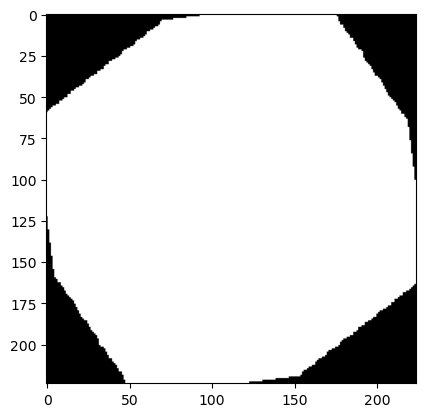

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


In [22]:
test, label = train_data.__getitem__(0)
# visualize test image
plt.imshow(test.permute(1, 2, 0), cmap='gray')
plt.show()
print(label)

In [23]:
batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16, 114])


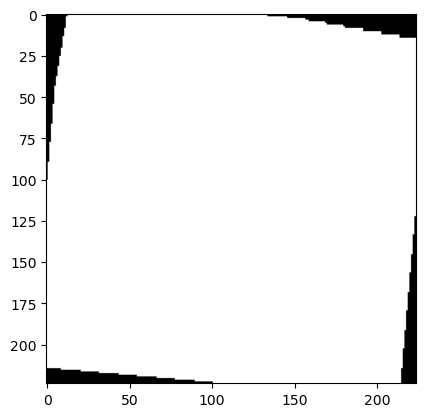

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


In [24]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")

In [50]:
class ResNetWithDropout(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetWithDropout, self).__init__()
        pre_resnet = resnet18(weights=ResNet18_Weights.DEFAULT) if pretrained else resnet18(weights=None)
        # create a new resnet model, starting with no layer, then add one by one, and its weights
        self.resnet = torch.nn.Sequential()
        # add the first 4 layers of the pre-trained resnet model
        for name, layer in pre_resnet.named_children():
            if name == 'fc' or name == 'avgpool':
                break
            self.resnet.add_module(name, layer)
        # add a dropout layer
        self.resnet.dropout = torch.nn.Dropout(p=0.5)
        # add the last 2 layers of the pre-trained resnet model
        for name, layer in pre_resnet.named_children():
            if name == 'fc' or name == 'avgpool':
                self.resnet.add_module(name, layer)
        # change the final fully connected layer to have 114 output features
        self.resnet.fc = torch.nn.Linear(in_features=512, out_features=114, bias=True)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        # Add dropout (for Monte Carlo) before the final fully connected layer
        x = self.resnet.dropout(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x

In [51]:

model_mode = 'pretrained'
model = ResNetWithDropout(pretrained=True) if model_mode == 'pretrained' else ResNetWithDropout(pretrained=False)
model_weights_path = 'resnet18_pretrained.pth' if model_mode == 'pretrained' else 'resnet18.pth'
model.train()

ResNetWithDropout(
  (resnet): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [104]:
# find all the images that does not have size 3x244x244 and print out its index
for i, (images, labels) in enumerate(train_dataloader):
    c = images.size()[1]
    h = images.size()[2]
    w = images.size()[3]
    if ( c != 3 or h != 224 or w != 224):
        print(i, images.size()[1:])

KeyboardInterrupt: 

In [53]:
# train resnet18 with 50 epochs, validate every epoch, and use early stopping
# save trainingloss, training accuracy, validation loss and accuracy for each epoch
# if validation loss does not decrease in 5 decimal places for 10 epochs, stop training
# if validation loss does not decrease in 5 decimal places for 3 epochs, reduce learning rate by 10%

#configure device to use gpu



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 100
early_stopping_count = 10
best_loss = 100
best_acc = 0
val_loss_list = []
val_acc_list = []
lr = 0.0001
dropout_p = 0.3
n_mc_samples = 10 # number of monte carlo samples
model.train()
model.resnet.dropout.p = dropout_p
# configure resnet18 to use gpu
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [49]:

# print start time
print(f"Start training at {datetime.datetime.now()}")
for epoch in range(epochs):
    #record start time
    start_time = datetime.datetime.now()
    # train
    train_loss = 0
    train_acc = 0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # repeat forward pass with different dropout masks
        outputs_list = []
        for j in range(n_mc_samples):
            outputs = model(images)
            outputs_list.append(outputs)
        outputs = torch.stack(outputs_list)
        # compute loss and backpropagate gradients
        loss = criterion(outputs.mean(dim=0), torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.mean(dim=0).argmax(1) == torch.argmax(labels, dim=1)).sum().item()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_data)
    # validate
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            # repeat forward pass with different dropout masks
            outputs_list = []
            for j in range(n_mc_samples):
                outputs = model(images)
                outputs_list.append(outputs)
            outputs = torch.stack(outputs_list)
            val_loss += criterion(outputs.mean(dim=0), torch.argmax(labels, dim=1)).item()
            val_acc += (outputs.mean(dim=0).argmax(1) == torch.argmax(labels, dim=1)).sum().item()
    val_loss /= len(val_dataloader)
    val_acc /= len(val_data)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.3f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.3f}')
    # print end time, and eslaped minutes 
    end_time = datetime.datetime.now()
    print(f"End training at {end_time}")
    print(f"Epoch train time: {(end_time - start_time).seconds / 60} minutes")
    # early stopping
    if (val_loss - best_loss) < 0.00001:
        best_loss = val_loss
        best_acc = val_acc
        # save model
        torch.save(model.state_dict(), model_weights_path)
        early_stop = 0
    else:
        early_stop += 1
    if early_stop == early_stopping_count:
        print('Early stopping')
        break


AttributeError: 'ResNetWithDropout' object has no attribute 'dropout'

In [111]:
# count number of images in ./data

len(os.listdir('./data'))

16530

In [55]:
#load model state from resnet18.pth
model.load_state_dict(torch.load('resnet18_pretrained_03.pth', map_location=torch.device('cpu')))
model.eval()
# test with test data and monte carlo dropout
# record test loss and accuracy
# record the predicted label
test_loss = 0
test_acc = 0
pred_list = []
truy_list = []
with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # repeat forward pass with different dropout masks
        outputs_list = []
        for j in range(n_mc_samples):
            outputs = model(images)
            outputs_list.append(outputs)
        outputs = torch.stack(outputs_list)
        test_loss += criterion(outputs.mean(dim=0), torch.argmax(labels, dim=1)).item()
        test_acc += (outputs.mean(dim=0).argmax(1) == torch.argmax(labels, dim=1)).sum().item()
        pred_list.append(outputs.mean(dim=0).argmax(1))
        truy_list.append(torch.argmax(labels, dim=1))
test_loss /= len(test_dataloader)
test_acc /= len(test_data)

KeyboardInterrupt: 

Test Loss: 1353.99600 | Test Acc: 1444.000


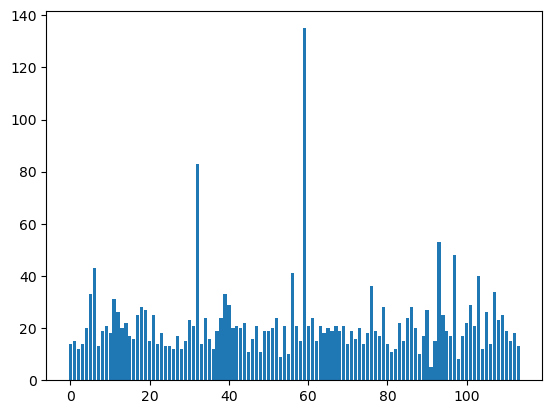

In [62]:
# count the number of each predicted label and plot the bar chart
label_count_dict = {}
for i in range(114):
    label_count_dict[i] = 0
for i in range(len(pred_list)):
    label_count_dict[pred_list[i].item()] += 1
plt.bar(label_count_dict.keys(), label_count_dict.values())


# print test loss and accuracy
print(f'Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.3f}')

<BarContainer object of 114 artists>

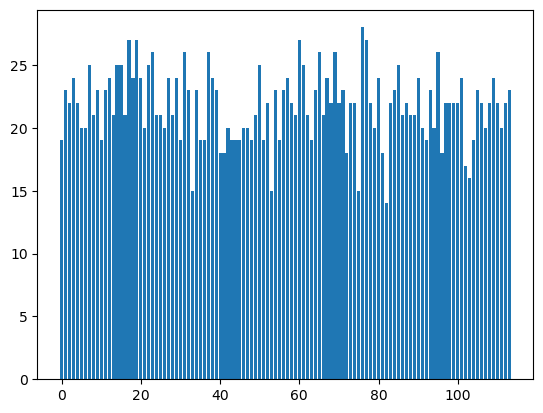

In [64]:
label_count_dict = {}
for i in range(114):
    label_count_dict[i] = 0
for i in range(len(truy_list)):
    label_count_dict[truy_list[i].item()] += 1
plt.bar(label_count_dict.keys(), label_count_dict.values())

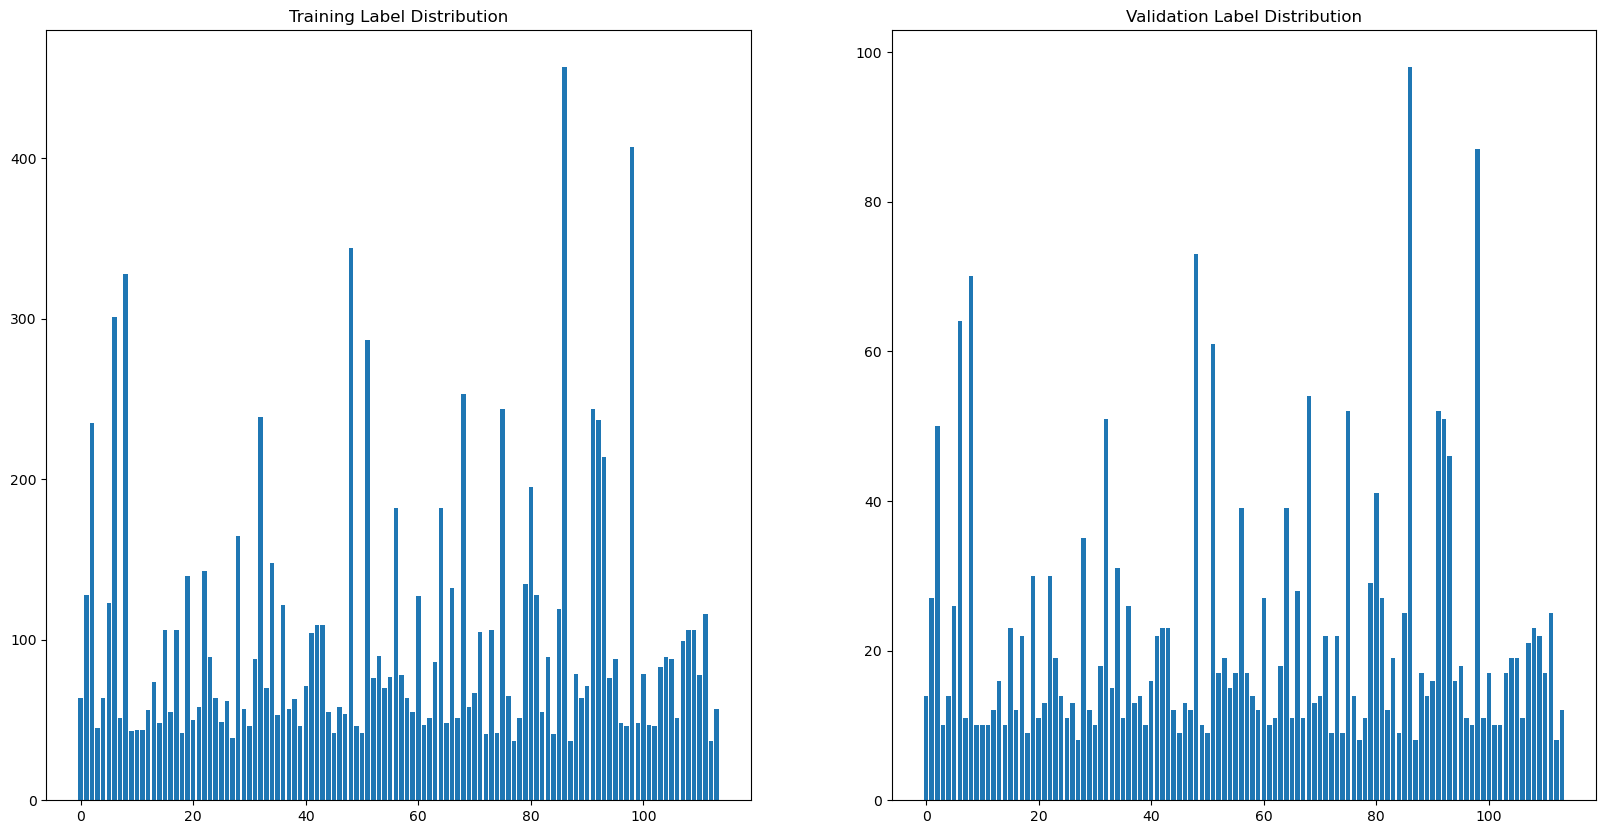

In [120]:
# plot training label distribution and validation label distribution using train_df and val_df

train_label = train_df['label_code'].value_counts()
val_label = val_df['label_code'].value_counts()
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.bar(train_label.index, train_label.values)
plt.title('Training Label Distribution')
plt.subplot(1, 2, 2)
plt.bar(val_label.index, val_label.values)
plt.title('Validation Label Distribution')
plt.show()


In [8]:
# Replicate resnet18 model to an empty model without pretrained weights

model = resnet18(weights=None)

# Load pretrained weights from resnet18.pth
model.state_dict = torch.load('06_resnet18.pth', map_location=torch.device('cpu'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# test with test data and monte carlo dropout
# record test loss and accuracy
# record the predicted label
# save predicted probability for each obersvation
n_mc_samples = 10 
test_loss = 0
test_acc = 0
pred_list = []
pred_prob_list = []
true_list = []
with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # repeat forward pass with different dropout masks
        outputs_list = []
        for j in range(n_mc_samples):
            outputs = model(images)
            outputs_list.append(outputs)
        outputs = torch.stack(outputs_list)
        test_loss += criterion(outputs.mean(dim=0), torch.argmax(labels, dim=1)).item()
        test_acc += (outputs.mean(dim=0).argmax(1) == torch.argmax(labels, dim=1)).sum().item()
        # get predicted probability for each observation
        pred_prob_list.append(outputs.mean(dim=0).softmax(1))

        pred_list.append(outputs.mean(dim=0).argmax(1))
        true_list.append(torch.argmax(labels, dim=1))
test_loss /= len(test_dataloader)
test_acc /= len(test_data)
print(f'Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.3f}')

11200.0